In [34]:
import numpy as np
import matplotlib.pyplot as plt
from poke.beamlets import prop_complex_curvature, det_2x2
# from scipy.opimize import nnls
%matplotlib ipympl

# Define the aperture function (rectangular)
def rectangular_aperture(x, width):
    return np.where(np.abs(x) <= width / 2, 1, 0)

def tophat(x, R, m):
    return np.exp(-np.sqrt((x**2)/(R**2))**m)

# Waist
def w_z(w0, z, zR):
    return w0 * np.sqrt(1 + (z / zR) ** 2)

# Rayleigh Range
def R(z, z_r):
    return z * (1 + (z_r / z) ** 2)

# Q matrix
def Q_inv(z, z_r, w0, wl):
    return 1 / R(z, z_r) + 1j * wl / (np.pi * w_z(w0, z, z_r) ** 2)

# Rayleigh distance
def zR(w0, wavelength):
    return (np.pi * w0 ** 2) / wavelength

def gaussian_beam(E0, x, x0, y, y0, w0, zR):
    return E0 * (w0 / w_z(w0, 0, zR)) * np.exp(- ((x - x0) + (y - y0) / w_z(w0, 0, zR)) ** 2)

# Function to propagate a distance z, and obtain the new optical path length. 
def propagate(x, y, z, L, M, N, z_prop, opl):
    dx = (L / N) * z_prop
    dy = (M / N) * z_prop
    dz = (N / N) * z_prop
    x1 = x + dx
    y1 = y + dy
    z1 = z + dz
    
    opl = opl + np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    
    return x1, y1, z1, opl

def convert_slope_to_direction_cosines(dx, dy):
    l = dx / np.sqrt(1 + dx ** 2 + dy ** 2)
    m = dy / np.sqrt(1 + dx ** 2 + dy ** 2)
    n = 1 / np.sqrt(1 + dx** 2 + dy ** 2)
    return l, m, n

def create_rayset(x, l, y, m, dx, dl, dy, dm, n_rays):
    # Initialize the rayset matrix
    rayset = np.zeros((5, 4, n_rays))
    
    # Populate the rayset with the given variations
    rayset[0, :, :] = [x, l, y, m]
    rayset[1, :, :] = [x + dx, l, y, m]
    rayset[2, :, :] = [x, l + dl, y, m]
    rayset[3, :, :] = [x, l, y + dy, m]
    rayset[4, :, :] = [x, l, y, m + dm]

    return rayset

def differential_matrix(rayset, dPx, dPy, dHx, dHy):
    
    x_cen_T = rayset[0, 0, :]
    x_px_T = rayset[1, 0, :]
    x_pl_T = rayset[2, 0, :]
    x_py_T = rayset[3, 0, :]
    x_pm_T = rayset[4, 0, :]
    
    l_cen_T = rayset[0, 1, :]
    l_px_T = rayset[1, 1, :]
    l_pl_T = rayset[2, 1, :]
    l_py_T = rayset[3, 1, :]
    l_pm_T = rayset[4, 1, :]

    y_cen_T = rayset[0, 2, :]
    y_px_T = rayset[1, 2, :]
    y_pl_T = rayset[2, 2, :]
    y_py_T = rayset[3, 2, :]
    y_pm_T = rayset[4, 2, :]

    m_cen_T = rayset[0, 3, :]
    m_px_T = rayset[1, 3, :]
    m_pl_T = rayset[2, 3, :]
    m_py_T = rayset[3, 3, :]
    m_pm_T = rayset[4, 3, :]

    # Computing each element of the matrix
    ABCD = np.array([
        [(x_px_T - x_cen_T) / dPx, (x_py_T - x_cen_T) / dPy, (x_pl_T - x_cen_T) / dHx, (x_pm_T - x_cen_T) / dHy],
        [(y_px_T - y_cen_T) / dPx, (y_py_T - y_cen_T) / dPy, (y_pl_T - y_cen_T) / dHx, (y_pm_T - y_cen_T) / dHy],
        [(l_px_T - l_cen_T) / dPx, (l_py_T - l_cen_T) / dPy, (l_pl_T - l_cen_T) / dHx, (l_pm_T - l_cen_T) / dHy],
        [(m_px_T - m_cen_T) / dPx, (m_py_T - m_cen_T) / dPy, (m_pl_T - m_cen_T) / dHx, (m_pm_T - m_cen_T) / dHy]
    ])
    
    ABCD = ABCD.transpose(2, 0, 1)
    A = ABCD[:, 0:2, 0:2]
    B = ABCD[:, 0:2, 2:4]
    C = ABCD[:, 2:4, 0:2]
    D = ABCD[:, 2:4, 2:4]
    
    return A, B, C, D

def make_detector(dsize, npix, z_prop):
    x = np.linspace(-dsize/2,dsize/2,npix)
    x,y = np.meshgrid(x,x)

    return np.asarray([x.ravel(),y.ravel(),z_prop*np.ones_like(x.ravel())])

Best to start with a single gaussian, and how to divide that up into a bunch of rays. 

In [35]:
# Setup parameters
raybundle_extent = 30
wavelength = 1.0
wo = 3

div = wavelength / (np.pi * wo)
z_r = (np.pi * wo ** 2) / wavelength

z_ray = 0.0
n_rays = 10

# Setup coordinates
x = np.linspace(-raybundle_extent, raybundle_extent, n_rays)
x, y = np.meshgrid(x, x)

X = x
Y = y

x_ray = x.ravel()
y_ray = y.ravel()

n_rays = len(x_ray)
dx_ray = np.zeros_like(x_ray)
dy_ray = np.zeros_like(y_ray)

z0 = np.zeros((5, n_rays))
opd_in = np.zeros((5, n_rays))

# Propagation distance
z_prop = 100

# Differential quantities for each gaussian
dPx = wo
dPy = wo
dHx = div / np.sqrt(1 + div ** 2 + div ** 2) #direction cosine rather than slope
dHy = div / np.sqrt(1 + div ** 2 + div ** 2)

# Make coordinate bundle of gaussian raysets. 
rayset0 = create_rayset(x_ray, dx_ray, y_ray, dy_ray, dPx, dHx, dPy, dHy, n_rays)

# Propagate raysets a distance in z. 
rayset1 = np.copy(rayset0)
rayset1[:, 0], rayset1[:, 2], z1, opd = propagate(rayset0[:, 0], rayset0[:, 2],  z0, 
                                                  rayset0[:, 1], rayset0[:, 3], 1 / (1 + rayset0[:, 1] ** 2 + rayset0[:, 3] ** 2), 
                                                  z_prop, opd_in)


In [36]:
A, B, C, D = differential_matrix(rayset1, dPx, dPy, dHx, dHy)
print(A.shape)

(100, 2, 2)


In [37]:
qinv = 1/(1j*z_r)
Qinv = np.asarray([[qinv,0],[0,qinv]])
Qinv = Qinv[np.newaxis]

Qpinv = prop_complex_curvature(Qinv,A,B,C,D)
Amplitude = 1/(np.sqrt(det_2x2(A + B @ Qpinv)))

In [38]:
z = z_prop * np.ones_like(z0)
z = z[:, np.newaxis, :]
zData = z[:, np.newaxis, :]
xData, yData = rayset1[:, np.newaxis, 0], rayset1[:, np.newaxis, 2]

n = (1 + rayset1[:, 1] ** 2 + rayset1[:, 3] ** 2)
nData = n[:, np.newaxis, :]
lData, mData = rayset1[:, np.newaxis, 1], rayset1[:, np.newaxis, 3]

xStart, yStart, zStart = rayset0[:, 0], rayset0[:, 2], 0.0 * zData[:, 0, 0]
lStart, mStart, nStart = rayset0[:, 1], rayset0[:, 3], 1 / (1 + rayset0[:, 1] ** 2 + rayset0[:, 3] ** 2)

xEnd, yEnd, zEnd = rayset1[:, 0], rayset1[:, 2], zData[:, 0, 0]
lEnd, mEnd, nEnd = rayset1[:, 1], rayset1[:, 3], 1 / (1 + rayset1[:, 1] ** 2 + rayset1[:, 3] ** 2)



In [39]:
from poke.beamlets import transversal_phase, center_transversal_plane, orthogonal_transformation_matrix, distance_to_transversal, propagate_rays_and_transform, optical_path_and_delta, differential_matrix_calculation_misaligned
k = 2 * np.pi / wavelength

r_ray_start = np.moveaxis(np.asarray([xStart,yStart,zStart]),0,-1)
k_ray_start = np.moveaxis(np.asarray([lStart,mStart,nStart]),0,-1)
r_ray = np.moveaxis(np.asarray([xEnd,yEnd,zEnd]),0,-1)
k_ray = np.moveaxis(np.asarray([lEnd,mEnd,nEnd]),0,-1)
dsize = 100
npix = 256

dcoords = make_detector(dsize, npix, z_prop)
dnorm = np.array([[0., 0., 1.]])


In [42]:


from poke.beamlets import extra_factors, determine_misalingment_vectors
rho_1,the_1,rho_2,the_2 = determine_misalingment_vectors(r_ray_start[0],r_ray[0],k_ray_start[0],k_ray[0])
field = np.zeros([dcoords.shape[1]],dtype=np.complex128)

# digest the dcoords
dcoords = np.moveaxis(dcoords,-1,0)

# Compute the Ray Transfer Matrices
A = differential_matrix_calculation_misaligned(r_ray[0,...,0],r_ray[0,...,1], # central ray central_u,v
                                            r_ray[1,...,0],r_ray[1,...,1], # waist_x diff_uu,uv
                                            r_ray[2,...,0],r_ray[2,...,1], # waist_y diff_vu,vv
                                            dPx,dPy)
        
C = differential_matrix_calculation_misaligned(k_ray[0,...,0],k_ray[0,...,1], # central ray central_u,v
                                            k_ray[1,...,0],k_ray[1,...,1], # waist_x diff_uu,uv
                                            k_ray[2,...,0],k_ray[2,...,1], # waist_y diff_vu,vv
                                            dPx,dPy)

B = differential_matrix_calculation_misaligned(r_ray[0,...,0],r_ray[0,...,1], # central ray central_u,v
                                            r_ray[3,...,0],r_ray[3,...,1], # diverge_x diff_uu,uv
                                            r_ray[4,...,0],r_ray[4,...,1], # diverge_y diff_vu,vv
                                            dHx,dHy)

D = differential_matrix_calculation_misaligned(k_ray[0,...,0],k_ray[0,...,1], # central ray central_u,v
                                            k_ray[3,...,0],k_ray[3,...,1], # diverge_x diff_uu,uv
                                            k_ray[4,...,0],k_ray[4,...,1], # diverge_y diff_vu,vv
                                            dHx,dHy)

Qpinv = prop_complex_curvature(Qinv,A,B,C,D)
Amplitude = 1/(np.sqrt(det_2x2(A + B @ Qpinv)))
detpixels = np.broadcast_to(dcoords,[Qpinv.shape[0],*dcoords.shape])
detpixels = np.swapaxes(detpixels,0,1) # subtract central ray position
detpixels = detpixels[...,:2] # - np.broadcast_to(rho_2,[detpixels.shape[0],*rho_2.shape])
phi = 1j*k/2 * extra_factors(rho_1,detpixels,B,A)

transversal = -1j*k*transversal_phase(Qpinv,detpixels - np.broadcast_to(rho_2,[detpixels.shape[0],*rho_2.shape]))

OPD = 1j*k*OPD[0]
OPD = np.broadcast_to(OPD,[detpixels.shape[0],*OPD.shape])
guoy = -1j*guoy_phase(Qpinv)
field += np.sum(vignetted*Amplitude*ne.evaluate('exp(transversal + OPD + phi + guoy)'),-1)
# field_misaligned = np.zeros([dcoords.shape[1]],dtype=np.complex128)
# field_misaligned += np.sum(Amplitude*np.exp(transversal),-1)
# field_misaligned = field_misaligned.reshape(npix,npix)

(3, 100)


/home/landers/MonteCarloMS/.conda/lib/python3.11/site-packages/poke/poke_math.py:103: RuntimeWarning: divide by zero encountered in divide
  matinv = np.array([[d, -b], [-c, a]]) / det
/home/landers/MonteCarloMS/.conda/lib/python3.11/site-packages/poke/poke_math.py:103: RuntimeWarning: invalid value encountered in divide
  matinv = np.array([[d, -b], [-c, a]]) / det
/home/landers/MonteCarloMS/.conda/lib/python3.11/site-packages/poke/beamlets.py:236: RuntimeWarning: invalid value encountered in matmul
  return NUM @ DEN
/tmp/ipykernel_1008429/571603942.py:26: RuntimeWarning: invalid value encountered in divide
  Amplitude = 1/(np.sqrt(det_2x2(A + B @ Qpinv)))
/home/landers/MonteCarloMS/.conda/lib/python3.11/site-packages/poke/beamlets.py:591: RuntimeWarning: invalid value encountered in add
  cross = (rho_1m[...,0]*Binv[...,0,0] + rho_1m[...,1]*Binv[...,1,0])*rho_2[...,0]
/tmp/ipykernel_1008429/571603942.py:35: RuntimeWarning: overflow encountered in exp
  field_misaligned += np.sum(Amp

ValueError: operands could not be broadcast together with shapes (65536,) (3,) (65536,) 

Meat and potatoes of calculation. 5 functions from Poke that allow to calculate the phase of the gaussian at each pixel on the detector. 

Essentially we are performing this computation:

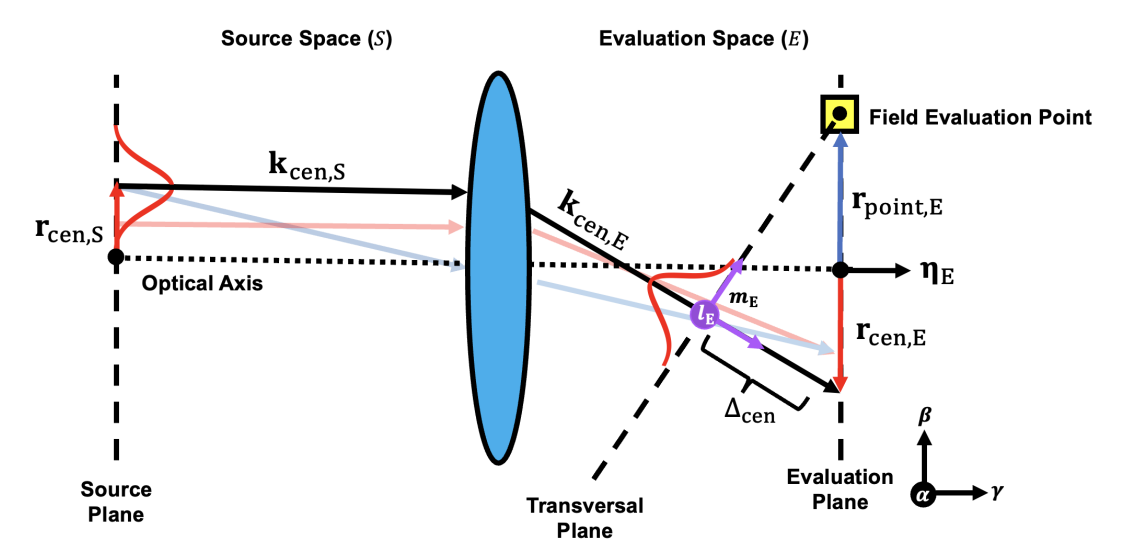

In [ ]:
# O = orthogonal_transformation_matrix(k_ray[0],dnorm)
# Delta = distance_to_transversal(dcoords,r_ray,k_ray)
# r_ray,k_ray = propagate_rays_and_transform(r_ray,k_ray,Delta,O)
# r = center_transversal_plane(dcoords, r_ray, O)
# transversal = -1j*k*transversal_phase(Qpinv,r)
# opticalpath = -1j*k*optical_path_and_delta(opd,Delta)

# field = np.zeros([dcoords.shape[1]],dtype=np.complex128)
# field += np.sum(Amplitude*np.exp(transversal),axis=1)
# field = field.reshape(npix,npix)

n shape =  (100, 3)
r shape =  (3, 65536)
n @ r shape (5, 100, 65536)


Faster version of evaluating gaussians at detector, which rotates the gaussian to the plane of the detector, instead of moving the gaussian along it's propagation direction perpendicular to each pixel. See "A Generalized Expression for Accelerating
Beamlet Decomposition Simulations" - https://arxiv.org/pdf/2404.12454

(3, 100)


ValueError: operands could not be broadcast together with shapes (3,100,2) (3,65536,100,3,2) 

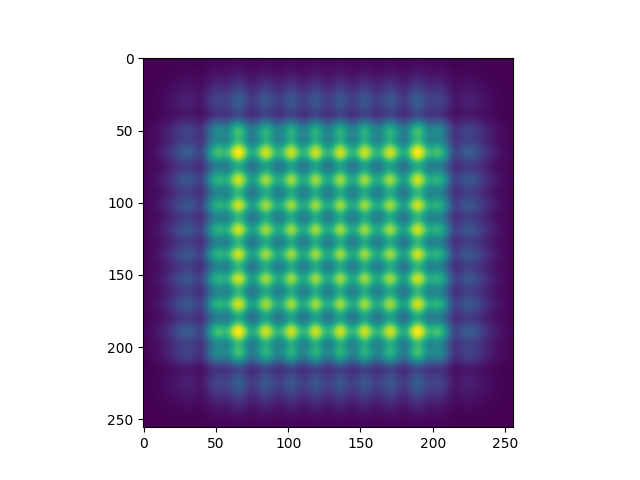

In [ ]:
plt.figure()
plt.imshow(np.abs(field))

In [ ]:
# plt.figure()
# plt.plot(z_ray, w_z(wo, z_ray, z_r))
# plt.plot(z_ray, w_z(-wo, z_ray, z_r))
# plt.plot(z0, rayset0[:, 0], '.b')
# plt.plot([z0, z1], [rayset0[:, 0], rayset1[:, 0]],  '-r')

In [ ]:
# wo = 0.4
# Wtotal = 20
# Wfield = 10

# OF = 2
# Ng = int(round(Wfield * OF / (2 * wo)))

# Cb = 2 * wo / OF
# print(Ng, Cb)

# pixels = 10001
# xtotal = np.linspace(-Wtotal/2, Wtotal/2, pixels)
# xfield = np.linspace(-Wfield/2, Wfield/2, pixels)

# field = np.ones(pixels) + 1j * np.zeros(pixels)  # This is your given field

# x0s = np.linspace(-Wfield/2 - (Cb*Ng - Wfield)/2, Wfield/2 + (Cb*Ng - Wfield)/2, Ng)
# print(x0s)

In [ ]:
# field = tophat(xtotal, Wfield/2, 20)

# plt.figure()
# plt.plot(xtotal, np.abs(field))

In [ ]:
# # Construct matrix G
# G = np.zeros((pixels, Ng), dtype=complex)
# gaussian_components = []
# z_r = zR(wo, 1.0)

# for j in range(Ng):
#     x0 = x0s[j]  # Centers of Gaussians
#     gaussian = gaussian_beam(1.0, xtotal, x0, wo, z_r)
#     G[:, j] = gaussian
#     gaussian_components.append(gaussian)

# # Solve for coefficients c using non-negative least squares (NNLS)
# c, _ = nnls(np.abs(G), np.abs(field))

# # Plot the original field and the reconstructed field
# reconstructed_field = np.dot(np.abs(G), c)



In [ ]:
# plt.figure(figsize=(8, 4))

# # Plot the individual Gaussian components
# plt.subplot(1, 1, 1)
# for j in range(Ng):
#     plt.plot(xtotal, np.abs(gaussian_components[j]), '-r', label=f'Gaussian {j+1}')

# plt.plot(xtotal, np.abs(field), label='Original Field (Amplitude)')
# plt.plot(xtotal, np.abs(reconstructed_field), '--k', label='Reconstructed Field (Amplitude)')
# plt.xlabel('Position (x)')
# plt.ylabel('Amplitude')
# plt.title('Comparison of Original and Reconstructed Fields')

# plt.tight_layout()
# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the grid
# x = np.linspace(-10, 10, 200)
# y = np.linspace(-10, 10, 200)
# X, Y = np.meshgrid(x, y)
# r = np.sqrt(X**2 + Y**2)

# # Parameters
# sigma = 2
# wavelength = 1
# k = 2 * np.pi / wavelength

# # Calculate the phases
# phase_spherical = k * r
# phase_gaussian = k * np.exp(-r**2 / (2 * sigma**2))

# # Plot the equiphase lines
# plt.figure(figsize=(10, 5))

# # Spherical Point Source (solid lines)
# contour_spherical = plt.contour(X, Y, phase_spherical, levels=20, colors='black', linestyles='solid')
# plt.clabel(contour_spherical, inline=1, fontsize=8)

# # Gaussian Point Source (dashed lines)
# contour_gaussian = plt.contour(X, Y, phase_gaussian, levels=20, colors='black', linestyles='dashed')
# plt.clabel(contour_gaussian, inline=1, fontsize=8)

# # Add labels and title
# plt.xlabel('z')
# plt.ylabel('r')
# plt.title('Overlay of Phase Fronts for Spherical and Gaussian Point Sources with Wavelength')
# plt.grid(True)
# plt.axis('equal')

# plt.show()
